In [1]:
import numpy as np
from sklearn.model_selection import KFold
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import os
import math
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
import pandas as pd
from scipy import interpolate
import random
from utils.manifold_metrices import *


In [2]:
# load data
result_path = '../results/Ach-ver16/figures-for-ver16-final6/manifold-SRD-long-formal--3-40'
folder_name = 'cv_merge'
filename_train = 'data_merge_train.npy'
filename_test = 'data_merge_test.npy'
# statistics choice
statistics_choice = 'inter_cluster_distance' # 'inter_cluster_distance', 'within_cluster_distance','distance_ratio','distance_from_origin'
if_save = False
if if_save:
    figure_save_path = result_path +'/'+statistics_choice
    f = os.path.exists(figure_save_path)
    if not f:
        os.makedirs(figure_save_path)
# parameters
trial_seg_len = 180
num_trial = 180
num_dim = 2
time_range = range(0,43)
# stim
stim = np.array([3,1,2,3,2,1,3,1,2,1,2,3,1,2,3,2,3,1,3,2,1,2,3,1,2,3,1,2,1,3,2,3,1,2,3,1,3,1,2,3,1,2,3,2,1,2,1,3,2,1,3,1,2,3,1,2,3,2,1,3,1,2,3,2,1,3,1,3,2,3,2,1,3,2,1,3,1,2,3,2,1,3,1,2,3,2,1,2,3,1,
                 3,1,2,3,1,2,3,2,1,2,3,1,2,1,3,2,1,3,1,3,2,3,1,2,1,2,3,2,3,1,2,3,1,3,2,1,2,3,1,2,1,3,1,2,3,2,3,1,2,1,3,1,3,2,3,1,2,1,2,3,2,1,3,1,2,3,2,3,1,3,1,2,1,3,2,1,3,2,3,1,2,3,2,1,2,1,3,1,2,3])
# random.shuffle(stim)

In [3]:
# load data
data_merge_train = np.load(result_path+'/'+folder_name+'/'+filename_train)
data_merge_train = data_merge_train[:,:,time_range,:,:]
print(np.shape(data_merge_train))
data_merge_test = np.load(result_path+'/'+folder_name+'/'+filename_test)
data_merge_test = data_merge_test[:,:,time_range,:,:]
print(np.shape(data_merge_test))

(10, 3, 43, 180, 2)
(10, 3, 43, 180, 2)


In [4]:
# calculate distance
num_fly = np.size(data_merge_train,0)
num_channel_choice = np.size(data_merge_train,1)
distance_inter_cluster_train = np.zeros((num_fly,num_channel_choice,4,len(time_range),int(num_trial/trial_seg_len)))
distance_inter_cluster_test = np.zeros((num_fly,num_channel_choice,4,len(time_range),int(num_trial/trial_seg_len)))
trial_flag = np.array(range(num_trial))
for ii in range(num_fly):
    for j in range(num_channel_choice):
        data_train = np.squeeze(data_merge_train[ii,j,:,:,:]) 
        data_test = np.squeeze(data_merge_test[ii,j,:,:,:]) 
        for pp in range(int(num_trial/trial_seg_len)):
            ind = np.array(trial_flag>=pp*trial_seg_len) * np.array(trial_flag<(pp+1)*trial_seg_len)
            if statistics_choice == 'inter_cluster_distance':
                distance_inter_cluster_train[ii,j,:,:,pp] = compute_distance_inter_cluster(data_train[:,ind,:],stim[ind])
                distance_inter_cluster_test[ii,j,:,:,pp] = compute_distance_inter_cluster(data_test[:,ind,:],stim[ind])
            elif statistics_choice == 'within_cluster_distance':
                distance_inter_cluster_train[ii,j,:,:,pp] = compute_distance_within_cluster(data_train[:,ind,:],stim[ind])
                distance_inter_cluster_test[ii,j,:,:,pp] = compute_distance_within_cluster(data_test[:,ind,:],stim[ind])
            elif statistics_choice == 'distance_ratio':
                aa = compute_distance_within_cluster(data_train[:,ind,:],stim[ind])
                bb = compute_distance_inter_cluster(data_train[:,ind,:],stim[ind])
                cc = aa/bb
                cc[np.isnan(cc)] = 0
                cc[np.isinf(cc)] = 0
                distance_inter_cluster_train[ii,j,:,:,pp] = cc
                distance_inter_cluster_train[ii,j,:,0,pp] = 0
                aa = compute_distance_within_cluster(data_test[:,ind,:],stim[ind])
                bb = compute_distance_inter_cluster(data_test[:,ind,:],stim[ind])
                cc = aa/bb
                cc[np.isnan(cc)] = 0
                cc[np.isinf(cc)] = 0
                distance_inter_cluster_test[ii,j,:,:,pp] = cc
                distance_inter_cluster_test[ii,j,:,0,pp] = 0
            elif statistics_choice == 'distance_from_origin':
                distance_inter_cluster_train[ii,j,:,:,pp] = compute_distance_from_origin(data_train[:,ind,:],stim[ind])
                distance_inter_cluster_test[ii,j,:,:,pp] = compute_distance_from_origin(data_test[:,ind,:],stim[ind])


w:\0-WYL\pipeline\p5_representation_analysis\4-manifold-statistics-final\utils\manifold_metrices.py:107: RuntimeWarning: invalid value encountered in true_divide
  data = np.uint8(255*(data-dmin)/(dmax-dmin))


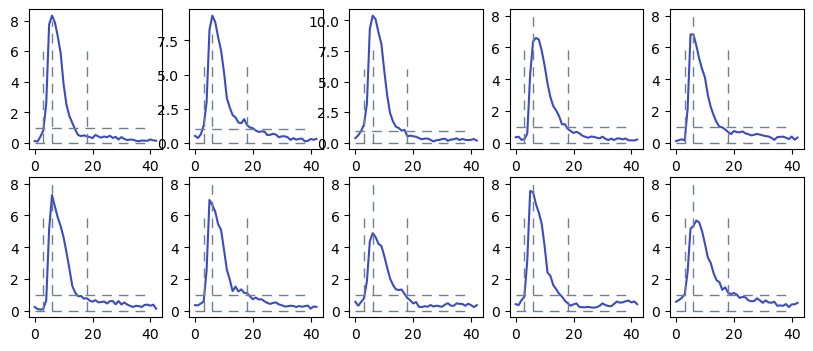

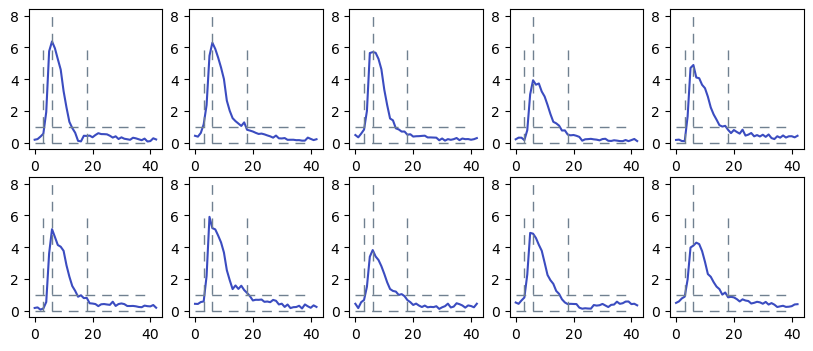

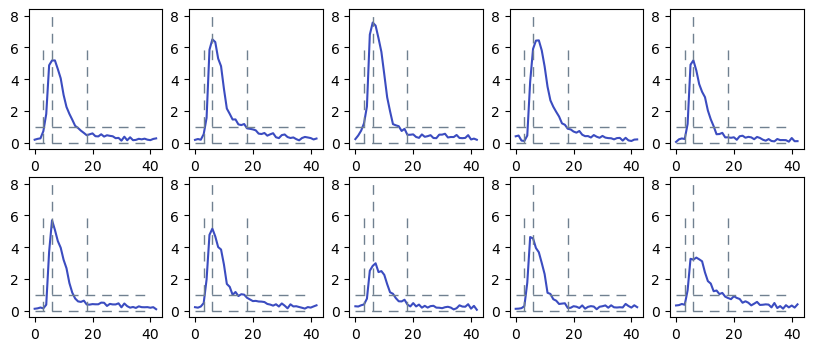

In [5]:
train_test = 1
odor_selected = 0
for j in range(num_channel_choice):
    plt.figure(figsize = (10,4))
    for i in range(num_fly):
        plt.subplot(2,5,i+1)
        fly_selected = i
        channel_selected = j
        if train_test == 0:
            the_data = np.squeeze(distance_inter_cluster_train[fly_selected,channel_selected,odor_selected,:,:])
        else:
            the_data = np.squeeze(distance_inter_cluster_test[fly_selected,channel_selected,odor_selected,:,:])

        cmap = 'coolwarm'
        colors = color_map(range(int(num_trial/trial_seg_len)), cmap)

        for pp in range(int(num_trial/trial_seg_len)):
            plt.plot(np.squeeze(the_data),color = colors[pp])
        plt.plot([3,3],[0,6],'--', linewidth=1, markersize=6, dashes = (7,5),color='slategray')
        plt.plot([18,18],[0,6],'--', linewidth=1, markersize=6, dashes = (7,5),color='slategray')
        plt.plot([0,40],[1,1],'--', linewidth=1, markersize=6, dashes = (7,5),color='slategray')
        plt.plot([0,40],[0,0],'--', linewidth=1, markersize=6, dashes = (7,5),color='slategray')
        plt.plot([6,6],[0,8],'--', linewidth=1, markersize=6, dashes = (7,5),color='slategray')

    if if_save:
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype'] = 42
        plt.savefig(figure_save_path + '/' + statistics_choice+'_'+'channel_'+str(channel_selected)+'_train_test_'+str(train_test)+'_odor_selected_'+str(odor_selected)+'-whole.png',dpi = 300,bbox_inches = 'tight')
        plt.savefig(figure_save_path + '/' + statistics_choice+'_'+'channel_'+str(channel_selected)+'_train_test_'+str(train_test)+'_odor_selected_'+str(odor_selected)+'-whole.pdf',dpi = 300,bbox_inches = 'tight')
        np.save(figure_save_path + '/' + statistics_choice+'_train-whole.npy',distance_inter_cluster_train)
        np.save(figure_save_path + '/' + statistics_choice+'_test-whole.npy',distance_inter_cluster_test)
    plt.show()

In [6]:
print(np.shape(distance_inter_cluster_train))
print(np.shape(distance_inter_cluster_test))

(10, 3, 4, 43, 1)
(10, 3, 4, 43, 1)


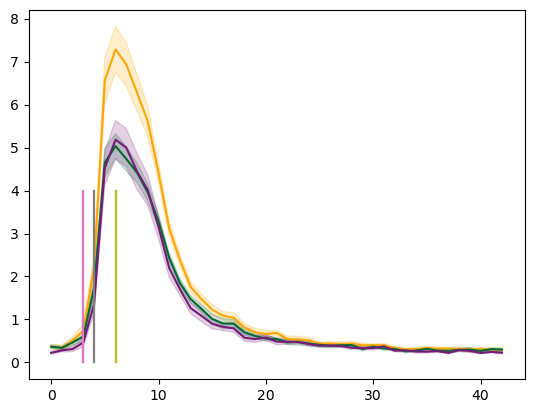

In [7]:
for i in range(3):
    a = np.squeeze(distance_inter_cluster_test[:,i,0,:,:])
    the_color = ['orange','#006934','#751C77']
    data = a
    xx = np.linspace(0,42,43)
    y = data
    the_mean = np.mean(y,0)
    the_std = np.std(y,0,ddof=1)/math.sqrt(np.size(y,0))
    yy_below = the_mean-the_std
    yy_above = the_mean+the_std
    plt.plot(xx, the_mean,color = the_color[i])
    x_fill = np.concatenate((xx,xx[::-1]),axis = 0)
    y_fill = np.concatenate((yy_below,yy_above[::-1]),axis = 0)
    plt.fill(x_fill,y_fill,color = the_color[i],alpha=0.2)
    plt.plot([3,3],[0,4])
    plt.plot([4,4],[0,4])
    plt.plot([6,6],[0,4])